<h1><b>Towards Object-Based Visual SLAM: A Revolution for Urban Tram</b></h1>

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import json
import ast
import cv2 
from collections import defaultdict
from tabulate import tabulate
from math import ceil

In [28]:
%matplotlib inline

### Helper functions

In [ ]:
#  Function to convert JSON annotations to a DataFrame

def json_to_dataframe(annot_path, dataset_name='unknown'):
    ds = dataset_name.lower()
    records = []

    for fname in os.listdir(annot_path):
        if not fname.endswith('.json'):
            continue

        path = os.path.join(annot_path, fname)
        with open(path, 'r') as f:
            ann = json.load(f)

        base = os.path.splitext(fname)[0] 
        file_ext = '.jpg' if ds == 'bdd100k' else '.png'

        if not base.endswith(file_ext):
            file_name = base + file_ext
        else:
            file_name = base

        for obj in ann.get('objects', []):
            ext = obj.get('points', {}).get('exterior', [])
            if len(ext) < 2:
                continue 
            xmin, ymin = ext[0]
            xmax, ymax = ext[1]

            rec = {
                'file': file_name,
                'type': obj.get('classTitle', 'unknown'),
                'bbox_xmin': xmin,
                'bbox_ymin': ymin,
                'bbox_xmax': xmax,
                'bbox_ymax': ymax
            }

            if ds == 'bdd100k':
                attr = next(
                    (t for t in obj.get('tags', []) if t.get('name') == 'attributes'),
                    {}
                )
                try:
                    d = ast.literal_eval(attr.get('value', '{}'))
                    rec['occluded'] = d.get('occluded', 'unknown')
                    rec['truncated'] = d.get('truncated', 'unknown')
                except Exception:
                    rec['occluded'] = 'unknown'
                    rec['truncated'] = 'unknown'
            
            elif ds == 'kitti':
                rec['occluded'] = next(
                    (t['value'] for t in obj.get('tags', []) if t.get('name') == 'occlusion state'),
                    'unknown'
                )
                rec['observation_angle'] = next(
                    (float(t['value']) for t in obj.get('tags', []) if t.get('name') == 'observation angle'),
                    0.0
                )
                dimensions = next(
                    (t['value'].split() for t in obj.get('tags', []) if t['name'] == 'dimensions'),
                    ['0.0', '0.0', '0.0']
                )
                rec['dimensions_h'] = float(dimensions[0]) if len(dimensions) > 0 else 0.0
                rec['dimensions_w'] = float(dimensions[1]) if len(dimensions) > 1 else 0.0
                rec['dimensions_l'] = float(dimensions[2]) if len(dimensions) > 2 else 0.0
                location = next(
                    (t['value'].split() for t in obj.get('tags', []) if t['name'] == 'location'),
                    ['0.0', '0.0', '0.0']
                )
                rec['location_x'] = float(location[0]) if len(location) > 0 else 0.0
                rec['location_y'] = float(location[1]) if len(location) > 1 else 0.0
                rec['location_z'] = float(location[2]) if len(location) > 2 else 0.0
                rec['rotation_y'] = next((float(t['value']) for t in obj.get('tags', []) if t['name'] == 'rotation y'), 0.0)
            
            else:
                raise ValueError(f'Unsupported dataset: {dataset_name}')

            records.append(rec)

    return pd.DataFrame(records) 

# <b>1. EDA (EXPLORATORY DATA ANALYSIS)</b>

In [29]:
KITTI_ANNOT_PATH = 'KITTI/train/ann'
KITTI_IMG_PATH = 'KITTI/train/img'
BDD100K_ANNOT_PATH = 'BDD100K/train/ann'

<h5>1.1 KITTI Object Detection Benchmark</h5>

In [31]:
# Convert KITTI JSON annotations to DataFrame

kitti_df = json_to_dataframe(KITTI_ANNOT_PATH, dataset_name='KITTI')

In [32]:
kitti_df.head()

,file,type,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,occluded,observation_angle,dimensions_h,dimensions_w,dimensions_l,location_x,location_y,location_z,rotation_y
0,002126.png,car,601,183,675,254,fully visible,-1.60,1.56,1.65,3.69,0.59,1.82,18.01,-1.57
1,002126.png,car,748,175,905,254,fully visible,-1.07,1.54,1.72,3.88,4.90,1.61,16.22,-0.78
2,002126.png,car,698,181,785,225,partly occluded,-0.96,1.52,1.49,3.46,4.96,1.83,27.13,-0.78
3,002126.png,car,671,183,747,215,largely occluded,-0.90,1.39,1.61,3.65,4.63,1.86,33.76,-0.76
4,002126.png,car,0,208,64,297,fully visible,2.33,1.34,1.57,4.01,-10.44,1.95,10.69,1.57


In [33]:
kitti_df.describe()

,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,observation_angle,dimensions_h,dimensions_w,dimensions_l,location_x,location_y,location_z,rotation_y
count,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000,51865.000000
mean,522.935563,172.390340,613.980719,235.388084,-2.267919,1.103321,0.977977,2.790421,-219.217034,-216.473156,-195.946024,-2.268226
std,264.862178,21.613621,263.531846,52.993629,4.375225,1.176088,1.119038,2.903059,412.046372,413.427009,424.538275,4.353582
min,0.000000,0.000000,8.000000,128.000000,-10.000000,-1.000000,-1.000000,-1.000000,-1000.000000,-1000.000000,-1000.000000,-10.000000
25%,366.000000,166.000000,454.000000,199.000000,-2.650000,1.360000,0.550000,0.780000,-17.940000,0.930000,5.290000,-2.720000
50%,547.000000,175.000000,585.000000,217.000000,-1.530000,1.500000,1.570000,3.610000,-4.310000,1.580000,18.750000,-1.560000
75%,684.000000,182.000000,744.000000,253.000000,1.660000,1.680000,1.670000,4.120000,2.550000,1.800000,33.800000,1.540000
max,1241.000000,349.000000,1241.000000,375.000000,3.140000,4.200000,3.010000,35.240000,40.060000,5.930000,146.850000,3.140000


In [ ]:
bbox_stat_kitti = kitti_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].describe().round(2)

print('\nSummary Statistics for Bounding Box Dimensions (KITTI):')
print(tabulate(bbox_stat_kitti, headers='keys', tablefmt='pretty'))


Summary Statistics for Bounding Box Dimensions:
+-------+-----------+-----------+-----------+-----------+
|       | bbox_xmin | bbox_ymin | bbox_xmax | bbox_ymax |
+-------+-----------+-----------+-----------+-----------+
| count |  51865.0  |  51865.0  |  51865.0  |  51865.0  |
| mean  |  522.94   |  172.39   |  613.98   |  235.39   |
|  std  |  264.86   |   21.61   |  263.53   |   52.99   |
|  min  |    0.0    |    0.0    |    8.0    |   128.0   |
|  25%  |   366.0   |   166.0   |   454.0   |   199.0   |
|  50%  |   547.0   |   175.0   |   585.0   |   217.0   |
|  75%  |   684.0   |   182.0   |   744.0   |   253.0   |
|  max  |  1241.0   |   349.0   |  1241.0   |   375.0   |
+-------+-----------+-----------+-----------+-----------+


/var/folders/wk/m8g2bm7n2z92gnr31mq5bbm40000gn/T/ipykernel_4626/2573684426.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


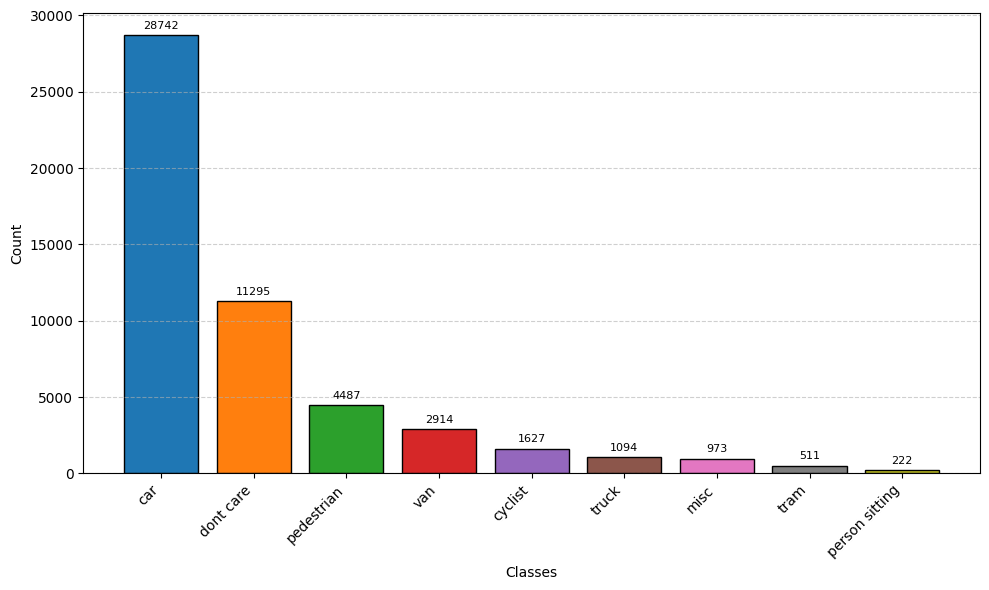

In [35]:
# Bar Chart: Distribution of Object Types

counts = kitti_df['type'].value_counts()
labels = counts.index.tolist()
values = counts.values
cmap = plt.get_cmap('tab10')
colors = cmap.colors[:len(labels)]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, values, color=colors, edgecolor='black')
# ax.set_title('Distribution of Object Types in KITTI')
ax.set_xlabel('Classes')
ax.set_ylabel('Count')
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords='offset points',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

- `Car` dominates, while `truck`, `tram` and `person sitting` are minority classes.
- This info provides insight that the prevalence of cars makes them ideal primary landmarks for SLAM.

Sample File: 002126.png
Sample Image Path: KITTI/train/img/002126.png


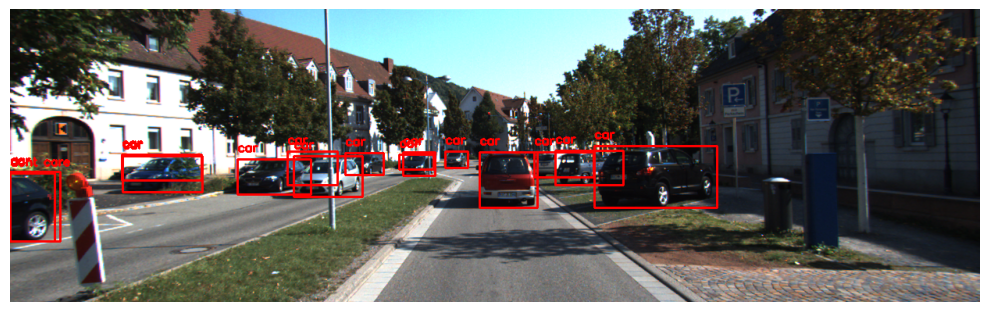

In [51]:
# Sample Image with Annotations

sample_file = kitti_df['file'].iloc[0]  
print(f'Sample File: {sample_file}')
sample_img_path = os.path.join(KITTI_IMG_PATH, sample_file)
print(f'Sample Image Path: {sample_img_path}')
if os.path.exists(sample_img_path):
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    annotations = kitti_df[kitti_df['file'] == sample_file]
    for index, row in annotations.iterrows():
        cv2.rectangle(img, (int(row['bbox_xmin']), int(row['bbox_ymin'])),
                     (int(row['bbox_xmax']), int(row['bbox_ymax'])), (255, 0, 0), 2)
        cv2.putText(img, row['type'], (int(row['bbox_xmin']), int(row['bbox_ymin'] - 10)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    # plt.title('Sample Image with Bounding Box Annotations')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f'Sample image {sample_img_path} not found.')

Sample File: 002126.png
Sample Image Path: KITTI/train/img/002126.png


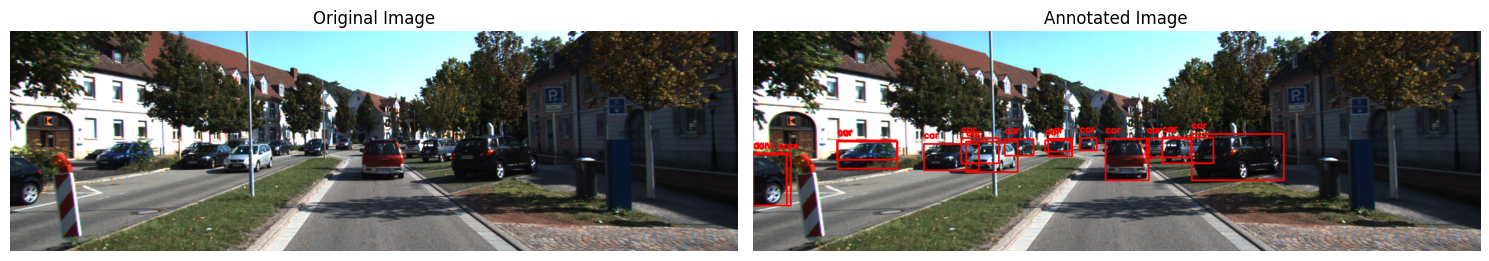

In [58]:
sample_file = kitti_df['file'].iloc[0]
print(f'Sample File: {sample_file}')
sample_img_path = os.path.join(KITTI_IMG_PATH, sample_file)
print(f'Sample Image Path: {sample_img_path}')

if os.path.exists(sample_img_path):
    # Load original image
    img_orig = cv2.imread(sample_img_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # Make a copy for annotations
    img_annot = img_orig.copy()

    # Filter annotations
    annotations = kitti_df[kitti_df['file'] == sample_file]

    # Draw bounding boxes and labels
    for _, row in annotations.iterrows():
        cv2.rectangle(
            img_annot,
            (int(row['bbox_xmin']), int(row['bbox_ymin'])),
            (int(row['bbox_xmax']), int(row['bbox_ymax'])),
            (255, 0, 0),
            2
        )
        cv2.putText(
            img_annot,
            row['type'],
            (int(row['bbox_xmin']), int(row['bbox_ymin']) - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2
        )

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(img_orig)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(img_annot)
    axs[1].set_title('Annotated Image')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print(f'Sample image {sample_img_path} not found.')

In [ ]:
# Display coordinate info for the first bounding box in the sample image

sample_annotations = kitti_df[kitti_df['file'] == sample_file]
if not sample_annotations.empty:
    bbox_info = sample_annotations.iloc[0]
    print(f'Bounding Box Coordinates for `{sample_file}`:')
    print(f'xmin: {bbox_info['bbox_xmin']}, ymin: {bbox_info['bbox_ymin']}, xmax: {bbox_info['bbox_xmax']}, ymax: {bbox_info['bbox_ymax']}')
else:
    print(f'No bounding box found for {sample_file}')

Bounding Box Coordinates for '002126.png':
xmin: 601, ymin: 183, xmax: 675, ymax: 254


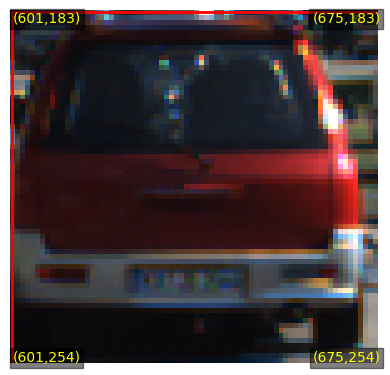

In [ ]:
# Sample Image with Bounding Box Crop

sample_file = kitti_df['file'].iloc[0]
annotations = kitti_df[kitti_df['file'] == sample_file]

sample_img_path = os.path.join(KITTI_IMG_PATH, sample_file)
if annotations.empty or not os.path.exists(sample_img_path):
    raise FileNotFoundError('No annotations or image for ' + sample_file)

img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

bbox = annotations.iloc[0]
xmin, ymin = int(bbox['bbox_xmin']), int(bbox['bbox_ymin'])
xmax, ymax = int(bbox['bbox_xmax']), int(bbox['bbox_ymax'])
obj_img = img[ymin:ymax, xmin:xmax]
h, w, _ = obj_img.shape 

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(obj_img, origin='upper')
ax.axis('off')

ax.add_patch(plt.Rectangle((0,0), w, h,
                           linewidth=2,
                           edgecolor='red',
                           facecolor='none'))

corners = [
    (0,   0,   f'({xmin},{ymin})', 'left',  'top'),
    (w,   0,   f'({xmax},{ymin})', 'right', 'top'),
    (w,   h,   f'({xmax},{ymax})', 'right', 'bottom'),
    (0,   h,   f'({xmin},{ymax})', 'left',  'bottom'),
]
for x, y, txt, ha, va in corners:
    ax.text(x, y, txt,
            color='yellow',
            fontsize=10,
            ha=ha, va=va,
            bbox=dict(facecolor='black', alpha=0.5, pad=2))

plt.tight_layout()
plt.show()

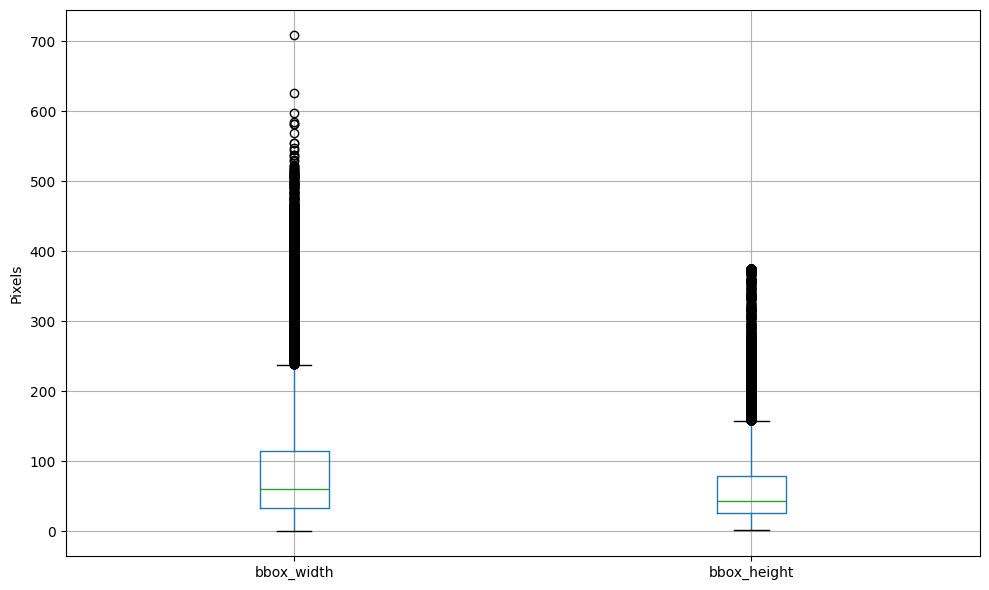

In [37]:
# Box Plot: Distribution of Bounding Box Dimensions

kitti_df['bbox_width'] = kitti_df['bbox_xmax'] - kitti_df['bbox_xmin']
kitti_df['bbox_height'] = kitti_df['bbox_ymax'] - kitti_df['bbox_ymin']
plt.figure(figsize=(10, 6))
kitti_df[['bbox_width', 'bbox_height']].boxplot()
# plt.title('Distribution of Bounding Box Dimensions (KITTI)')
plt.ylabel('Pixels')
plt.tight_layout()
plt.show()

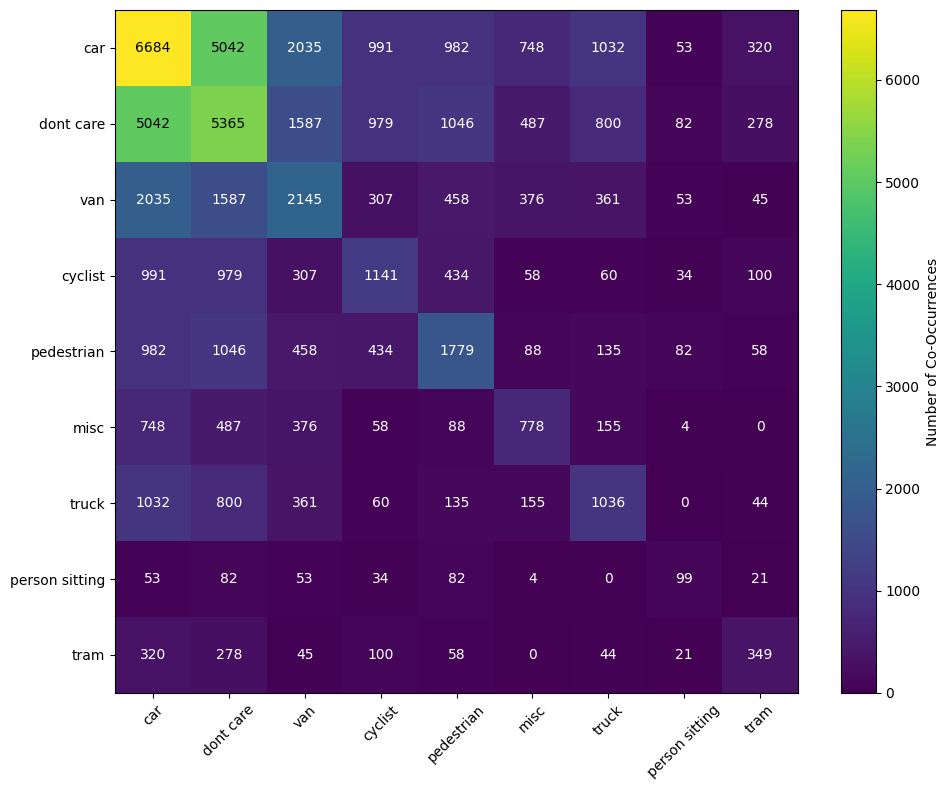

In [71]:
# Co-Occurrence Matrix

types_per_file = kitti_df.groupby('file')['type'].apply(list).to_dict()

co_occurrence = defaultdict(set)
for file, types in types_per_file.items():
    for obj_type in types:
        co_occurrence[obj_type].add(file)

object_types = kitti_df['type'].unique()
co_matrix = pd.DataFrame(0, index=object_types, columns=object_types, dtype=int)

for i, type1 in enumerate(object_types):
    for j, type2 in enumerate(object_types):
        if i <= j:  
            common_files = co_occurrence[type1] & co_occurrence[type2]
            co_matrix.iloc[i, j] = len(common_files)
            if i != j: 
                co_matrix.iloc[j, i] = len(common_files)

plt.figure(figsize=(10, 8))
plt.imshow(co_matrix, cmap='viridis', interpolation='nearest')
# plt.title('Co-Occurrence Matrix of Object Types in KITTI')
plt.xticks(ticks=range(len(object_types)), labels=object_types, rotation=45)
plt.yticks(ticks=range(len(object_types)), labels=object_types)
plt.colorbar(label='Number of Co-Occurrences')
for i in range(len(object_types)):
    for j in range(len(object_types)):
        count = co_matrix.iloc[i, j]
        plt.text(j, i, co_matrix.iloc[i, j], ha='center', va='center', color='black' if count > 5000 else 'white')
plt.tight_layout()
plt.show()

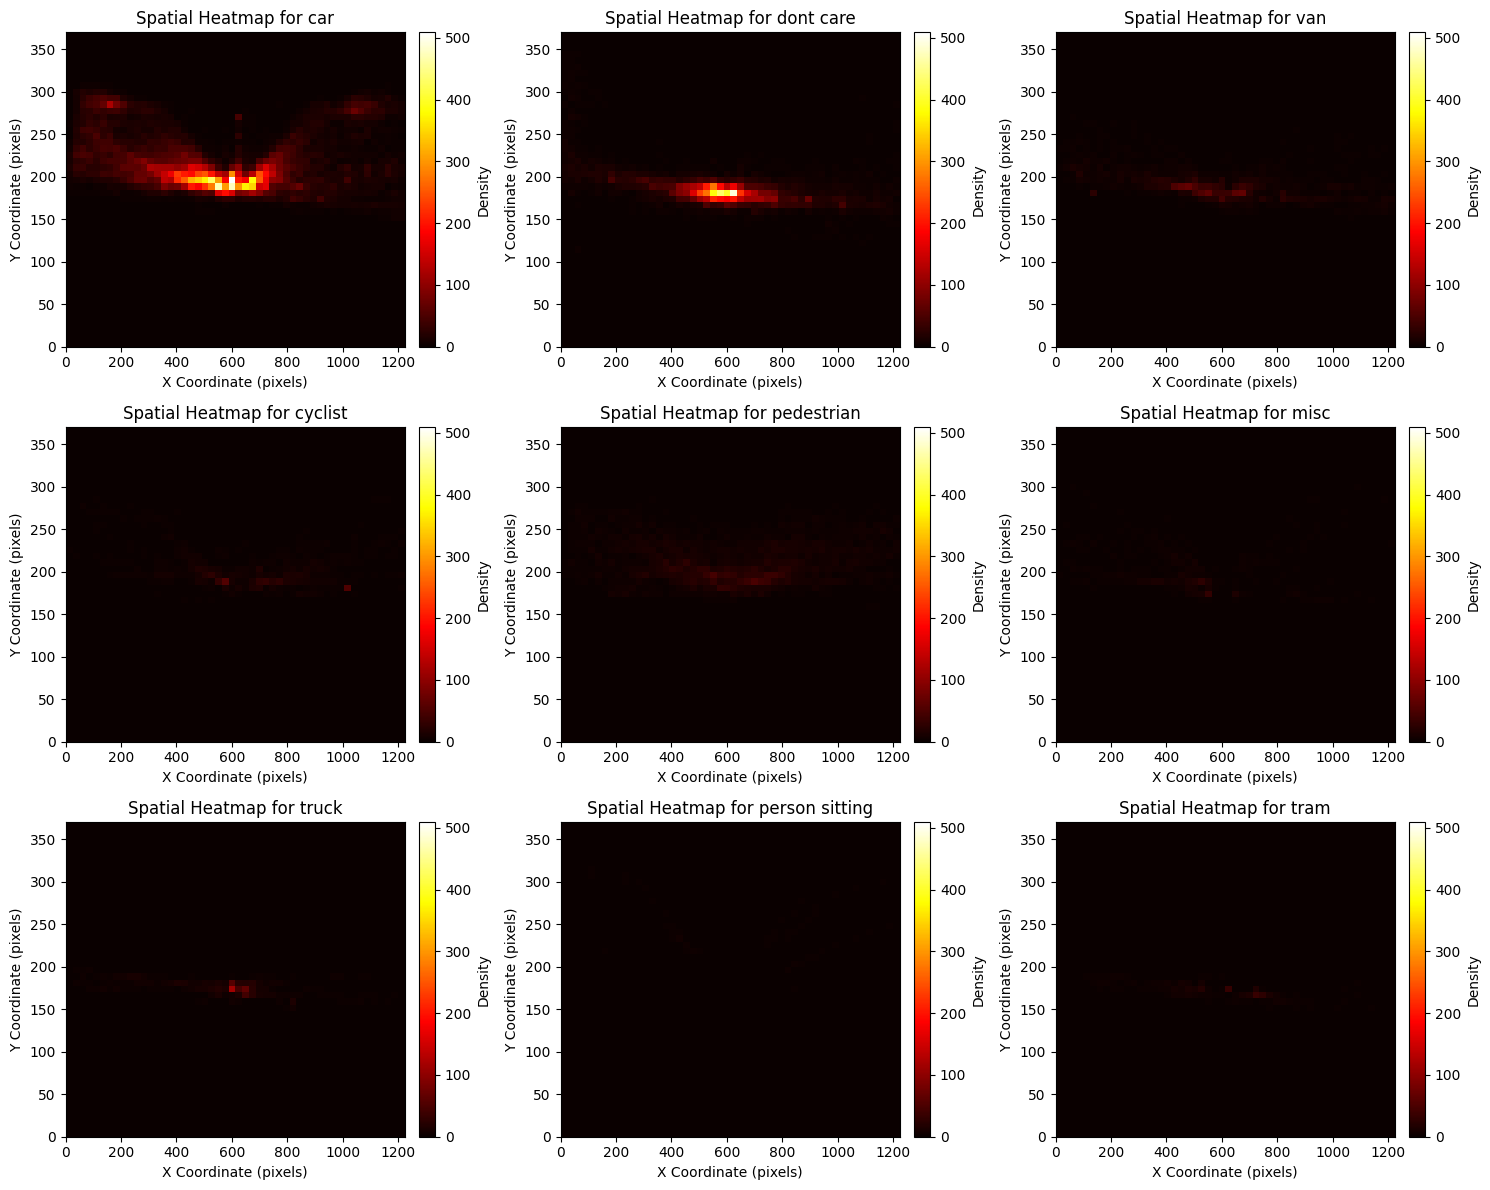

In [ ]:
# Spatial Heatmap for each object type

image_width = 1224  
image_height = 370  

kitti_data_individual = []
for json_file in os.listdir(KITTI_ANNOT_PATH):
    if json_file.endswith('.json'):
        json_file_path = os.path.join(KITTI_ANNOT_PATH, json_file)
        with open(json_file_path, 'r') as f:
            data = json.load(f)
            base_name = os.path.splitext(json_file)[0]
            file_name = f'{base_name}.png'
            objects = data.get('objects', [])
            for obj in objects:
                record = {
                    'file': file_name,
                    'type': obj.get('classTitle', 'unknown'),
                    'bbox_xmin': obj['points']['exterior'][0][0],
                    'bbox_ymin': obj['points']['exterior'][0][1],
                    'bbox_xmax': obj['points']['exterior'][1][0],
                    'bbox_ymax': obj['points']['exterior'][1][1]
                }
                kitti_data_individual.append(record)

kitti_df_individual = pd.DataFrame(kitti_data_individual)

image_width   = 1224
image_height  = 370
object_types  = kitti_df_individual['type'].unique().tolist()
n_types       = len(object_types)
n_cols        = 3
n_rows        = ceil(n_types / n_cols)

all_heatmaps = []
for t in object_types:
    df_t = kitti_df_individual[kitti_df_individual['type'] == t]
    x_centers = (df_t['bbox_xmin'] + df_t['bbox_xmax']) / 2
    y_centers = (df_t['bbox_ymin'] + df_t['bbox_ymax']) / 2
    heatmap, _, _ = np.histogram2d(
        x_centers, y_centers,
        bins=[50, 50],
        range=[[0, image_width], [0, image_height]]
    )
    all_heatmaps.append(heatmap.T)  

vmin = min(h.min() for h in all_heatmaps)
vmax = max(h.max() for h in all_heatmaps)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    sharex=False, sharey=False
)
axes = axes.flatten()

for idx, (ax, obj_type) in enumerate(zip(axes, object_types)):
    hm = all_heatmaps[idx]
    im = ax.imshow(
        hm,
        cmap='hot',
        origin='lower',
        extent=[0, image_width, 0, image_height],
        aspect='auto',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(f'Spatial Heatmap for {obj_type}')
    ax.set_xlabel('X Coordinate (pixels)')
    ax.set_ylabel('Y Coordinate (pixels)')
    
    cbar = fig.colorbar(
        im, ax=ax,
        fraction=0.046,  
        pad=0.04         
    )
    cbar.set_label('Density')

for j in range(n_types, len(axes)):
    axes[j].axis('off')

# fig.suptitle('Spatial Heatmaps of Object Classes (KITTI)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


<h5>1.2 BDD100K</h5>

In [40]:
# Convert BDD100K JSON annotations to DataFrame

bdd100k_df = json_to_dataframe(BDD100K_ANNOT_PATH, dataset_name='BDD100K')

In [41]:
bdd100k_df.head()

,file,type,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,occluded,truncated
0,703d912f-871ad2e4.jpg,traffic sign,796,130,856,210,False,False
1,703d912f-871ad2e4.jpg,traffic sign,766,279,840,329,False,False
2,703d912f-871ad2e4.jpg,car,783,373,801,410,True,False
3,703d912f-871ad2e4.jpg,car,675,387,689,412,True,False
4,703d912f-871ad2e4.jpg,car,559,369,598,410,True,False


In [42]:
bdd100k_df.describe()

,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
count,1.941794e+06,1.941794e+06,1.941794e+06,1.941794e+06
mean,5.595938e+02,3.457247e+02,6.114530e+02,3.907052e+02
std,3.035537e+02,1.161981e+02,3.262613e+02,1.229908e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.580000e+02,2.760000e+02,3.870000e+02,3.120000e+02
50%,5.600000e+02,3.400000e+02,5.940000e+02,3.810000e+02
75%,7.480000e+02,4.090000e+02,8.150000e+02,4.610000e+02
max,1.279000e+03,7.190000e+02,1.279000e+03,7.190000e+02


In [104]:
bbox_stat_bdd100k = bdd100k_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].describe().round(2)

print('\nSummary Statistics for Bounding Box Dimensions (BDD100K):')
print(tabulate(bbox_stat_bdd100k, headers='keys', tablefmt='pretty'))


Summary Statistics for Bounding Box Dimensions (BDD100K):
+-------+-----------+-----------+-----------+-----------+
|       | bbox_xmin | bbox_ymin | bbox_xmax | bbox_ymax |
+-------+-----------+-----------+-----------+-----------+
| count | 1941794.0 | 1941794.0 | 1941794.0 | 1941794.0 |
| mean  |  559.59   |  345.72   |  611.45   |  390.71   |
|  std  |  303.55   |   116.2   |  326.26   |  122.99   |
|  min  |    0.0    |    0.0    |    0.0    |    0.0    |
|  25%  |   358.0   |   276.0   |   387.0   |   312.0   |
|  50%  |   560.0   |   340.0   |   594.0   |   381.0   |
|  75%  |   748.0   |   409.0   |   815.0   |   461.0   |
|  max  |  1279.0   |   719.0   |  1279.0   |   719.0   |
+-------+-----------+-----------+-----------+-----------+


/var/folders/wk/m8g2bm7n2z92gnr31mq5bbm40000gn/T/ipykernel_4626/1778751046.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


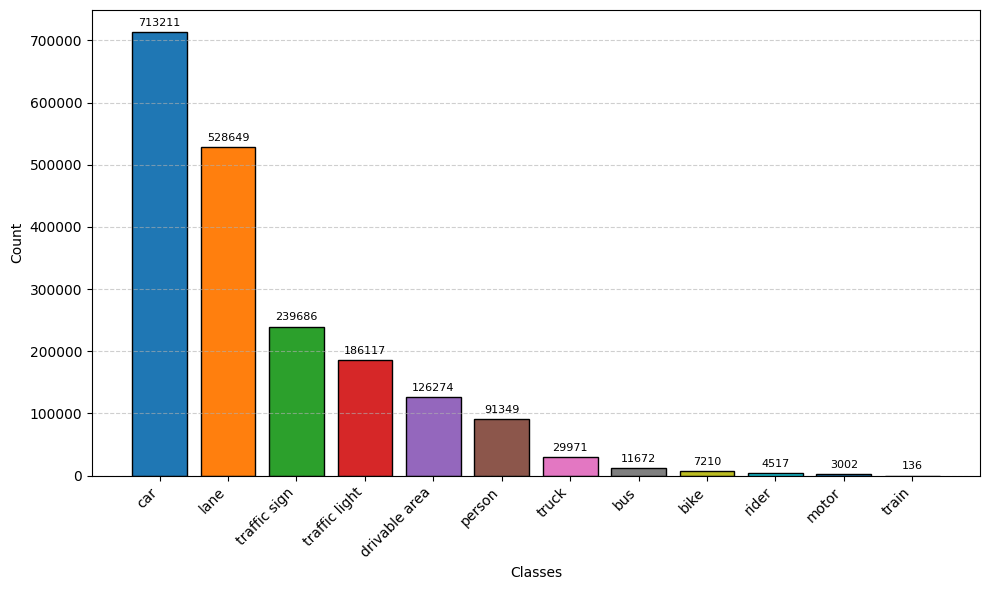

In [49]:
# Bar Chart: Distribution of Object Types

counts = bdd100k_df['type'].value_counts()
labels = counts.index.tolist()
values = counts.values
cmap = plt.get_cmap('tab10')
colors = cmap.colors[:len(labels)]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, values, color=colors, edgecolor='black')
# ax.set_title('Distribution of Object Types in BDD100K')
ax.set_xlabel('Classes')
ax.set_ylabel('Count')
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords='offset points',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Sample File: 0a006b7b-c22407a2.jpg
Sample Image Path: BDD100K/train/img/0a006b7b-c22407a2.jpg


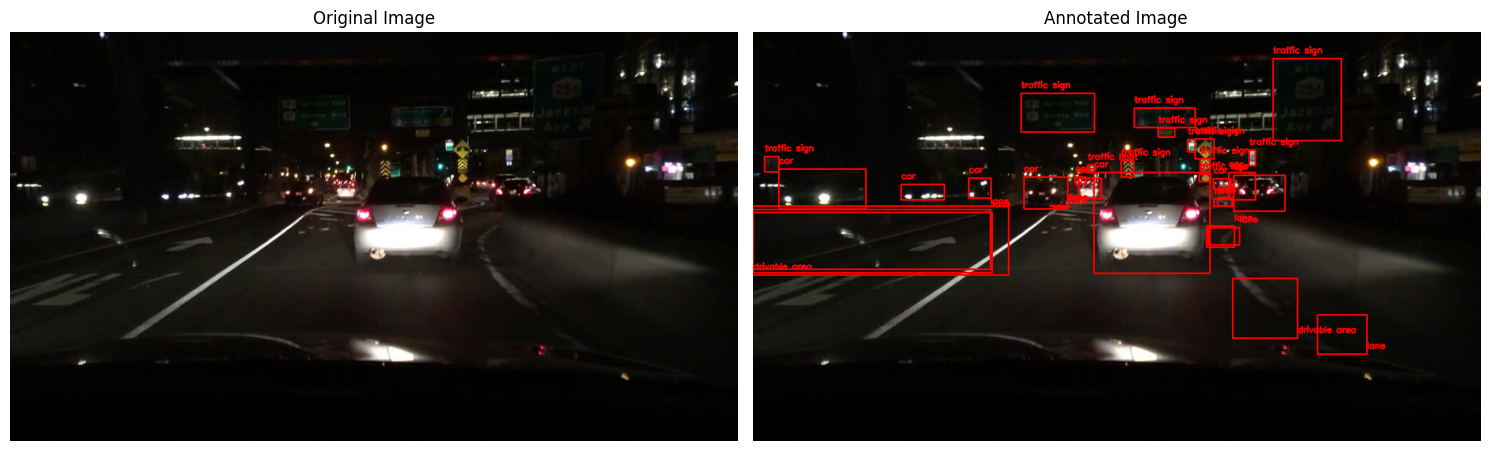

In [83]:
# Sample Image with Annotations for BDD100K

# sample_file = bdd100k_df['file'].iloc[0]
sample_file = '0a006b7b-c22407a2.jpg'
print(f'Sample File: {sample_file}')
sample_img_path = os.path.join('BDD100K/train/img', sample_file)
print(f'Sample Image Path: {sample_img_path}')

if os.path.exists(sample_img_path):
    img_orig = cv2.imread(sample_img_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    img_annot = img_orig.copy()

    annotations = bdd100k_df[bdd100k_df['file'] == sample_file]

    for _, row in annotations.iterrows():
        cv2.rectangle(
            img_annot,
            (int(row['bbox_xmin']), int(row['bbox_ymin'])),
            (int(row['bbox_xmax']), int(row['bbox_ymax'])),
            (255, 0, 0),
            2
        )
        cv2.putText(
            img_annot,
            row['type'],
            (int(row['bbox_xmin']), int(row['bbox_ymin']) - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2
        )

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(img_orig)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(img_annot)
    axs[1].set_title('Annotated Image')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print(f'Sample image {sample_img_path} not found.')

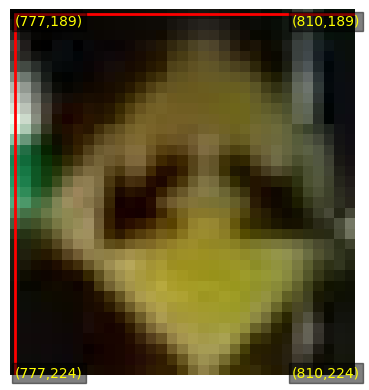

In [103]:
# Plot the cropped image with bounding box corner labels

# sample_file = bdd100k_df['file'].iloc[0]
annotations = bdd100k_df[bdd100k_df['file'] == sample_file]

sample_img_path = os.path.join('BDD100K/train/img', sample_file)
if annotations.empty or not os.path.exists(sample_img_path):
    raise FileNotFoundError('No annotations or image for ' + sample_file)

img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

bbox = annotations.iloc[15]
xmin, ymin = int(bbox['bbox_xmin']), int(bbox['bbox_ymin'])
xmax, ymax = int(bbox['bbox_xmax']), int(bbox['bbox_ymax'])

obj_img = img[ymin:ymax, xmin:xmax]
h, w, _ = obj_img.shape

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(obj_img, origin='upper')
ax.axis('off')

ax.add_patch(plt.Rectangle((0,0), w, h,
                           linewidth=2,
                           edgecolor='red',
                           facecolor='none'))

corners = [
    (0,   0,   f'({xmin},{ymin})', 'left',  'top'),
    (w,   0,   f'({xmax},{ymin})', 'right', 'top'),
    (w,   h,   f'({xmax},{ymax})', 'right', 'bottom'),
    (0,   h,   f'({xmin},{ymax})', 'left',  'bottom'),
]
for x, y, txt, ha, va in corners:
    ax.text(
        x, y, txt,
        color='yellow',
        fontsize=10,
        ha=ha,
        va=va,
        bbox=dict(facecolor='black', alpha=0.5, pad=2)
    )

plt.tight_layout()
plt.show()

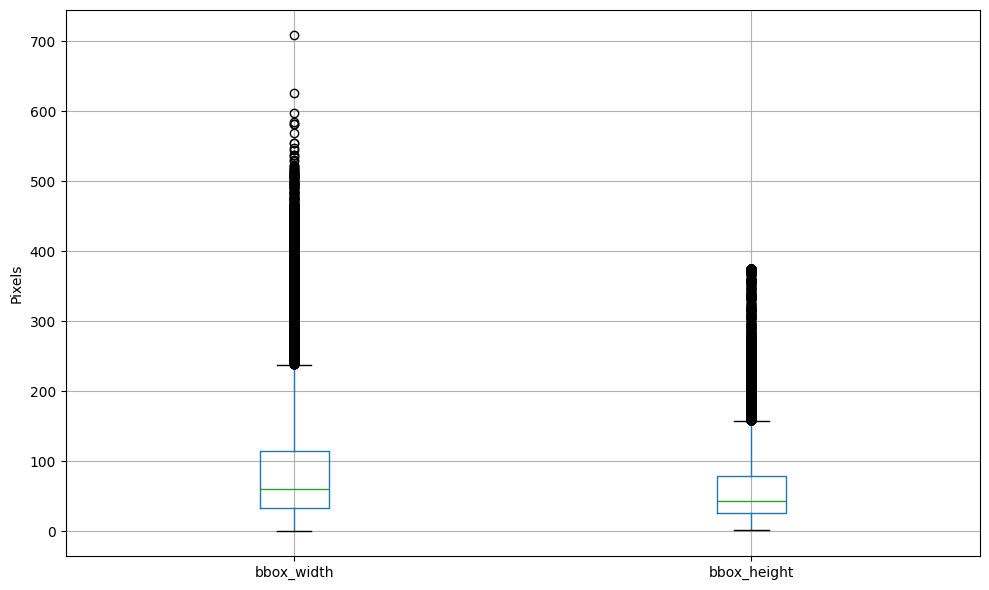

In [46]:
# Box Plot: Distribution of Bounding Box Dimensions

bdd100k_df['bbox_width'] = bdd100k_df['bbox_xmax'] - bdd100k_df['bbox_xmin']
bdd100k_df['bbox_height'] = bdd100k_df['bbox_ymax'] - bdd100k_df['bbox_ymin']
plt.figure(figsize=(10, 6))
kitti_df[['bbox_width', 'bbox_height']].boxplot()
# plt.title('Distribution of Bounding Box Dimensions (BDD100K)')
plt.ylabel('Pixels')
plt.tight_layout()
plt.show()

Total unique images: 69863
Sample co-occurrence (car & person): 21844


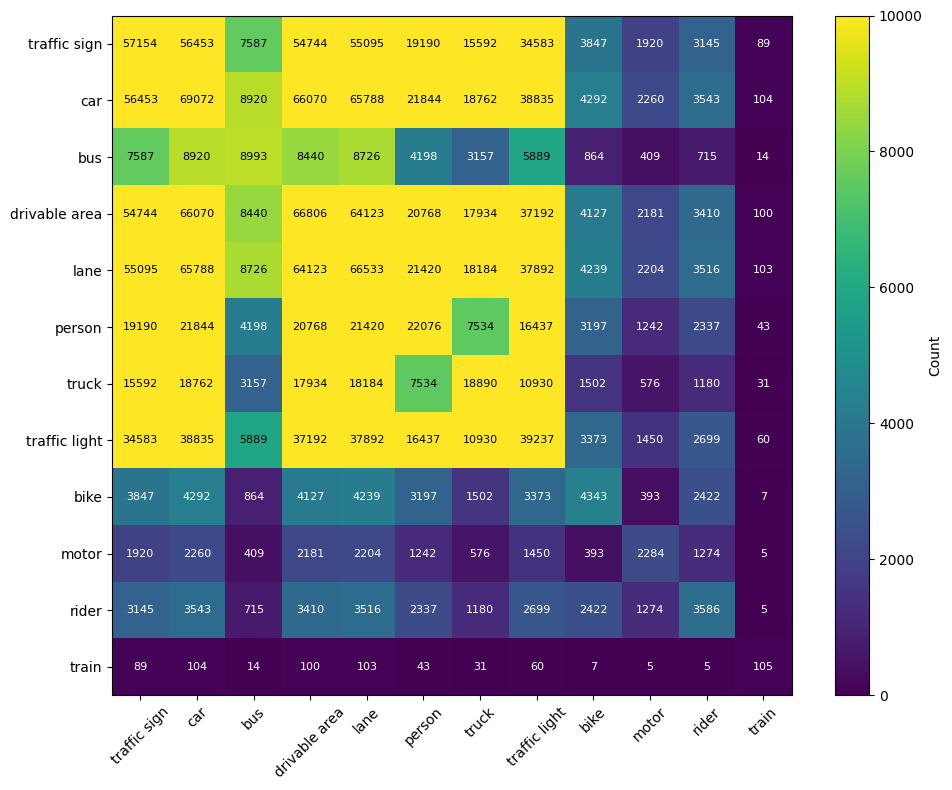

In [69]:
# Co-Occurrence Matrix Heatmap

types_per_file = bdd100k_df.groupby('file')['type'].apply(set).to_dict() 
co_occurrence = defaultdict(set)
for file, types in types_per_file.items():
    for obj_type in types:
        co_occurrence[obj_type].add(file)

# Use top 12 classes as per provided distribution
# top_classes = ['car', 'lane', 'traffic sign', 'traffic light', 'drivable area', 'person', 'truck', 'bus', 'bike', 'rider', 'motor', 'train']
top_classes = bdd100k_df['type'].unique()
co_matrix = pd.DataFrame(0, index=top_classes, columns=top_classes, dtype=int)

# Calculate unique images per class for diagonal
unique_images_per_class = {cls: len(co_occurrence[cls]) for cls in top_classes}

for i, type1 in enumerate(top_classes):
    for j, type2 in enumerate(top_classes):
        if i <= j:
            if i == j:
                # Diagonal: number of unique images with at least one instance of the class
                co_matrix.iloc[i, j] = unique_images_per_class[type1]
            else:
                # Off-diagonal: number of images where both types co-occur (unique pair per image)
                common_files = co_occurrence[type1] & co_occurrence[type2]
                co_matrix.iloc[i, j] = len(common_files)
                co_matrix.iloc[j, i] = len(common_files)

total_images = bdd100k_df['file'].nunique()
print('Total unique images:', total_images)
print('Sample co-occurrence (car & person):', len(co_occurrence['car'] & co_occurrence['person']))

plt.figure(figsize=(10, 8))
plt.imshow(co_matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=10000)
# plt.title('Co-Occurrence Matrix of Object Types in BDD100K Train Set')
plt.xticks(ticks=range(len(top_classes)), labels=top_classes, rotation=45)
plt.yticks(ticks=range(len(top_classes)), labels=top_classes)
plt.colorbar(label='Count')
for i in range(len(top_classes)):
    for j in range(len(top_classes)):
        count = co_matrix.iloc[i, j]
        plt.text(j, i, count if count > 0 else '', ha='center', va='center', color='black' if count > 5000 else 'white', fontsize=8)
plt.tight_layout()
plt.show()

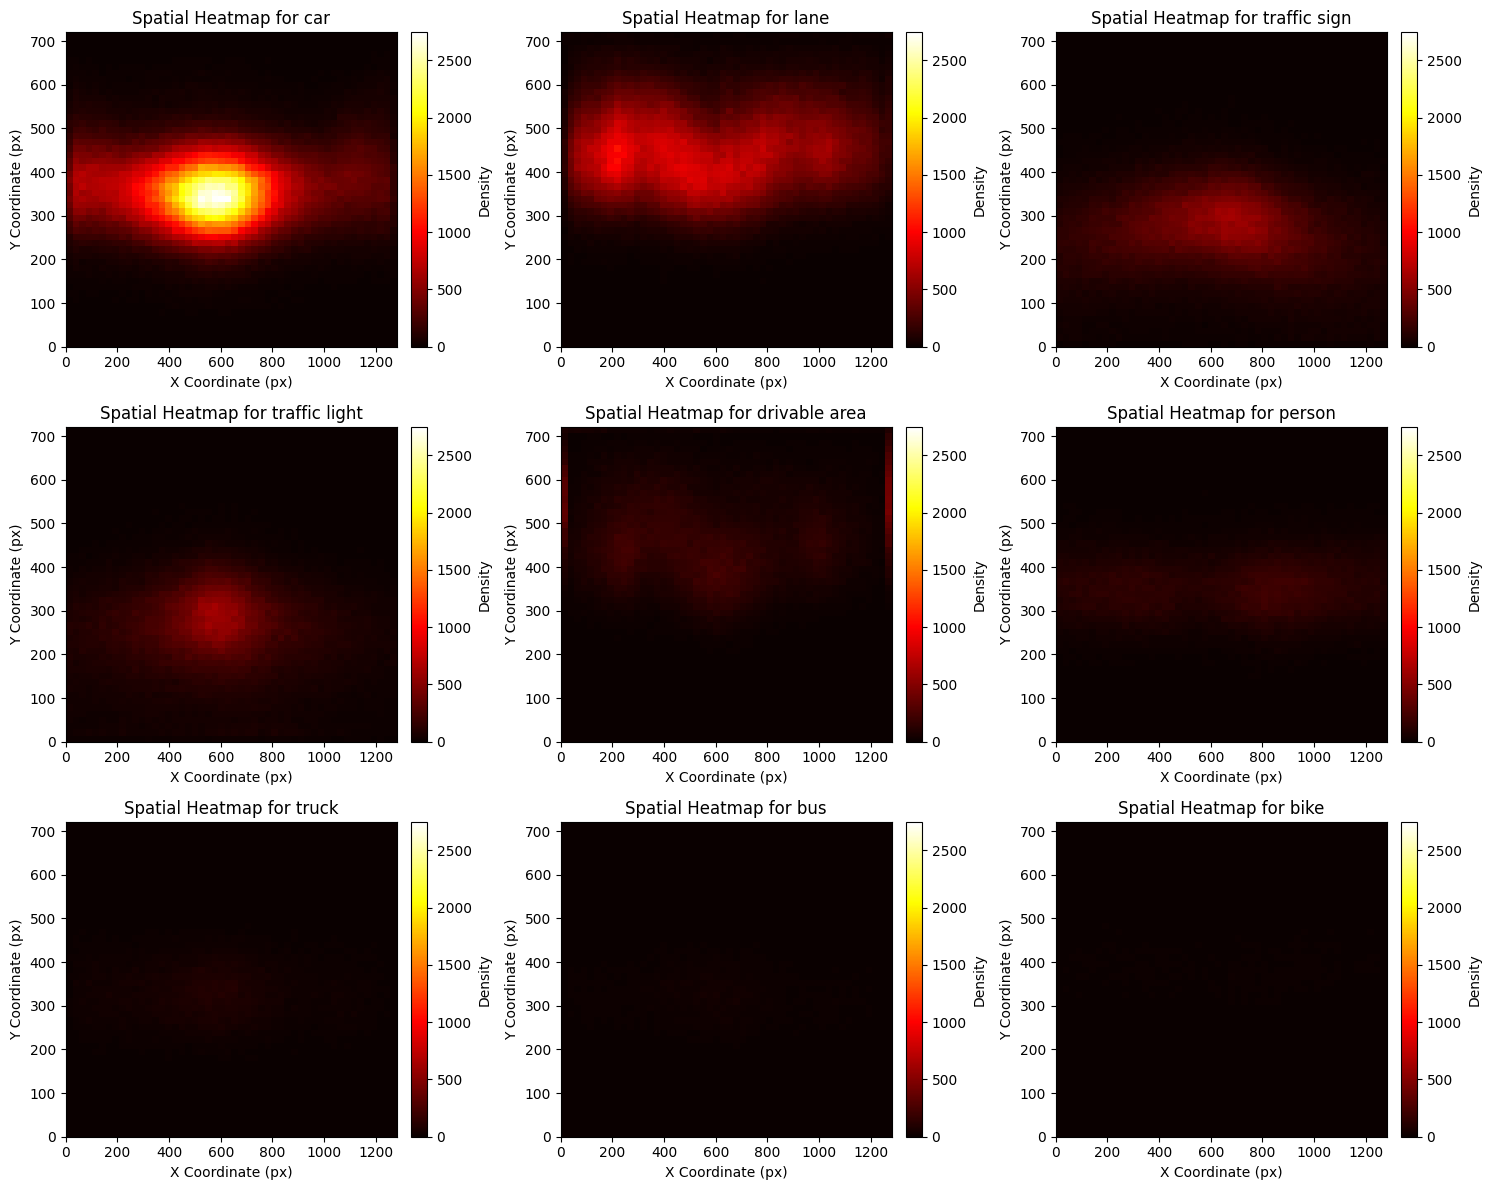

In [ ]:
# Spatial Heatmap for each object type in BDD100K

image_width, image_height = 1280, 720 
counts = bdd100k_df['type'].value_counts()
top9 = counts.head(9).index.tolist()  
n_types = len(top9)
n_cols = 3
n_rows = int(np.ceil(n_types / n_cols))

all_hms = []
for cls in top9:
    dfc = bdd100k_df[bdd100k_df['type'] == cls]
    x_ctr = (dfc['bbox_xmin'] + dfc['bbox_xmax']) / 2
    y_ctr = (dfc['bbox_ymin'] + dfc['bbox_ymax']) / 2

    hm, _, _ = np.histogram2d(
        x_ctr, y_ctr,
        bins=[50, 50],
        range=[[0, image_width], [0, image_height]]
    )
    all_hms.append(hm.T)

vmin = min(h.min() for h in all_hms)
vmax = max(h.max() for h in all_hms)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 4),
    squeeze=False
)
axes_flat = axes.flatten()

for idx, cls in enumerate(top9):
    ax = axes_flat[idx]
    im = ax.imshow(
        all_hms[idx],
        cmap='hot',
        origin='lower',
        extent=[0, image_width, 0, image_height],
        aspect='auto',
        vmin=vmin, vmax=vmax
    )
    # Add titles for each heatmap
    ax.set_title(f'Spatial Heatmap for {cls}')
    ax.set_xlabel('X Coordinate (px)')
    ax.set_ylabel('Y Coordinate (px)')

    cbar = fig.colorbar(
        im, ax=ax,
        fraction=0.046, pad=0.04
    )
    cbar.set_label('Density')

for j in range(n_types, len(axes_flat)):
    axes_flat[j].axis('off')

# fig.suptitle('Spatial Heatmaps of Object Classes (BDD100K)', y=1.02, fontsize=16)

plt.tight_layout()
plt.show()
